In [13]:
import os
import random

from collections import OrderedDict
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box, compute_ts_road_map
from hrnet import get_seg_model, get_config

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [15]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [16]:
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [17]:
labeled_scene_index = np.arange(106, 134)

In [18]:
train_index = np.arange(106,108)
val_index = np.arange(128,130)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=train_index,
    transform=transform,
    extra_info=False
    )

labeled_valset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=val_index,
    transform=transform,
    extra_info=False
    )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

model = get_seg_model(get_config()).to(device)

In [26]:
model.load_state_dict(torch.load('PT_FILES/HRNET_RM_labeled_data01.pt', map_location=device))

<All keys matched successfully>

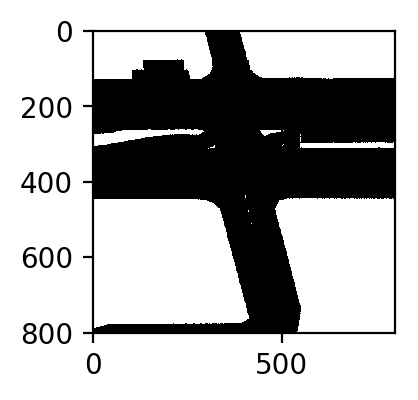

In [30]:
matplotlib.rcParams['figure.figsize'] = [2, 2]

# Visualize results
sample, target, road_image = iter(valloader).next()
image = sample[0].view(-1, 256, 306)

# True road image
fig, ax = plt.subplots()
ax.imshow(road_image[0], cmap='binary')

In [31]:
model.eval()

output = model(image.unsqueeze(0).to(device))
output

tensor([[[0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
         [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
         [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
         ...,
         [0.0650, 0.0650, 0.0650,  ..., 0.0752, 0.0752, 0.0752],
         [0.0650, 0.0650, 0.0650,  ..., 0.0752, 0.0752, 0.0752],
         [0.0650, 0.0650, 0.0650,  ..., 0.0752, 0.0752, 0.0752]]],
       grad_fn=<SqueezeBackward1>)

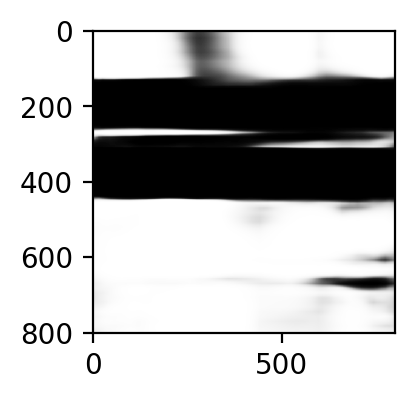

In [32]:
# Predicted road image
out_map = (output > 0.5).float()
fig, ax = plt.subplots()
ax.imshow(output.cpu().detach().numpy().squeeze(0), cmap='binary')